# SQL Database Reads

&copy; 2020 Kael HANSON (mailto:kael.hanson@icecube.wisc.edu)

I re-purposed an older script I had to skim out event and hit information from `.i3` files and put them into an SQL database in the tables

`events (id INTEGER PRIMARY KEY, file_id INTEGER, run_id INTEGER, evt_id INTEGER)`

and 

`hits (string INTEGER, module INTEGER, time REAL, charge REAL, event_id INTEGER)`

where `event_id` points back to the PRIMARY KEY `id` in `events`.

Somehow this seemed easier than writing another script to extract numpy arrays. But now of course I need to get the data out of the SQL database and into numpy arrays. This is how it's done.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import random

Here are some classes to make this look more like Python and less like SQL.

In [2]:
class OMKey:
    def __init__(self, string, module):
        self.string = string
        self.module = module
        
    def __repr__(self):
        return f'({self.string:02d},{self.module:02d})'

    def __eq__(self, other):
        if self.string == other.string and self.module == other.module: return True
        return False

class hit:
    def __init__(self, omkey, time, charge):
        self.omkey  = omkey
        self.time   = time
        self.charge = charge
        
    def __repr__(self):
        return str(self.omkey) + " " + f'time:{self.time:7.1f}, charge:{self.charge:6.2f}'

class event:
    def __init__(self, event_id, run_id):
        self.event_id = event_id
        self.run_id = run_id
        self.hits   = []

class I3EventDB:
    def __init__(self, filename):
        self.conn = sqlite3.connect(filename)

    def get_hits(self, evt_id):
        c = self.conn.cursor()
        query = """
        SELECT string, module, time, charge 
        FROM hits JOIN events ON events.id=hits.event_id 
        WHERE evt_id=:evt_id            
        """
        hits = []
        for row in c.execute(query, { "evt_id": evt_id }):
            hits.append(hit(OMKey(row[0], row[1]), row[2], row[3]))
        return hits

I couldn't think immediately how to best iterate on hits without explicitly iterating over events first. So first, open the database and get the list of event IDs for later use. The file `events-132694.db` contains MinBias filter events from run 132694 subruns 130-139. (About 30 minutes of live time). There are about 3500 events in this time span. I think the pre-scale factor is 1:2000 (every 2000th event that is readout by the IceCube DAQ is recorded even if it doesn't pass one of the _this physics is interesting_ filters.

In [3]:
conn = sqlite3.connect("data/events-132964.db")
c = conn.cursor()
event_ids = [row[0] for row in c.execute("SELECT evt_id FROM events")]
len(event_ids)

3476

In [4]:
db = I3EventDB('data/events-132964.db')

Text(0, 0.5, 'Frequency (a.u.)')

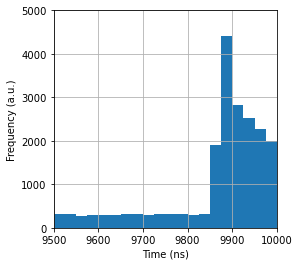

In [5]:
times = [row[0] for row in db.conn.execute("SELECT time FROM hits")]
fig = plt.figure(figsize=(4,4))
x = plt.hist(times, bins=np.arange(5000, 25000, 25))
plt.grid()
plt.axis((9500, 10000, 0, 5000))
plt.xlabel('Time (ns)')
plt.ylabel('Frequency (a.u.)')

Define a function to make 2d images from the hit lists. After some thought I have decided to go with a very basic translation from hits to 2d images in (z, t) - space: the triggered (i.e. not noise) hits occur after about 9800 ns (see histo above) and, as muons move through ~ $\sqrt{3}$ km - the max edge-to-edge distance in IceCube - it can take up to 5 us so this determines the time span of the arrays. Selecting $dt$ is a judgement call: IceCube time resolution is O(1) ns but scattering in the ice really washes this out so my guess is that 25 ns time binning is adequate.

In [6]:
def hits_to_array(hits, t0=9750.0, nt=200, dt=25.0):
    arr = np.zeros((86,60, nt), dtype='d')
    for h in hits:
        istr = h.omkey.string - 1
        irow = h.omkey.module - 1
        icol = int((h.time - t0) / dt)
        if irow < 60 and 0 < icol < nt: arr[istr,irow,icol] = h.charge
    return arr

In [31]:
Aevt = hits_to_array(db.get_hits(event_ids[18]), t0=9750., nt=50, dt=50)

In [32]:
for istr, q_tot in enumerate(np.sum(Aevt, axis=(1,2))):
    if q_tot > 0: print(f"String:{istr+1:2d} Qtot:{q_tot:.1f}")

String: 5 Qtot:0.3
String:15 Qtot:1.5
String:22 Qtot:2.3
String:23 Qtot:13.7
String:24 Qtot:0.9
String:25 Qtot:0.4
String:31 Qtot:16.8
String:32 Qtot:1.5
String:33 Qtot:1.0
String:37 Qtot:1.4
String:41 Qtot:0.4
String:80 Qtot:1.4
String:85 Qtot:0.7


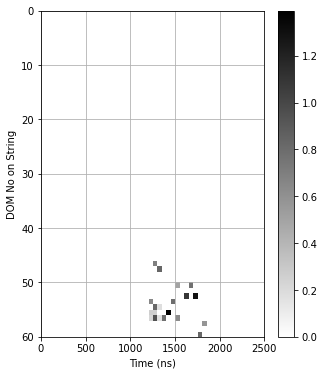

In [38]:
fig = plt.figure(figsize=(5, 6))
plt.imshow(Aevt[22,:,:], cmap='binary', extent=(0, 2500, 60, 0), aspect='auto')
plt.grid()
plt.xlabel('Time (ns)')
plt.ylabel('DOM No on String')
plt.colorbar()

Get some reasonably large number of images for a test training.

In [42]:
NT = 60
training_patterns = np.zeros((2500,60,NT,1),'d')
n = 0
i = 0
while True:
    Aevt = hits_to_array(db.get_hits(event_ids[i]), t0=9750., nt=NT, dt=50)
    for istr, q_tot in enumerate(np.sum(Aevt[:80], axis=(1,2))):
        if q_tot > 0: 
            if q_tot > 10 or random.uniform(0, 1) < 0.05:
                training_patterns[n] = Aevt[istr].reshape(60, NT, 1)
                n += 1
                if n == 2500: break
    i += 1
    if n == 2500: break

In [43]:
training_patterns.shape

(2500, 60, 60, 1)

In [44]:
np.sum(training_patterns[100:125],axis=(1,2,3))

array([11.9620335 ,  0.95796722,  4.62596428,  9.69452602, 17.32237162,
       33.32375428, 17.12109242, 15.43277808,  0.7720629 , 12.82076067,
        0.6202032 ,  8.870188  ,  4.4092319 ,  0.84006971,  0.45390761,
       17.19021247, 16.85645455,  1.6610893 , 13.1737735 , 16.18628043,
        1.42462167,  1.14375851,  1.02763176,  1.04889381,  1.26315534])

## On to the Autoencoder

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
ae_model = keras.models.Sequential([
    layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu', input_shape=(60, NT, 1)),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(60*NT, activation='sigmoid'),
    layers.Reshape(target_shape=(60,NT))
])

In [46]:
ae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=2.5E-5), 
                loss=keras.losses.Poisson(),
                metrics=['mse', 'poisson'])

In [47]:
ae_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 56, 56, 8)         208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               627300    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 3600)              363600    
_________________________________________________________________
reshape_2 (Reshape)          (None, 60, 60)           

In [48]:
trn = ae_model.fit(training_patterns, training_patterns.reshape(2500, 60, NT), batch_size=4, epochs=50, validation_split=0.1)

Train on 2250 samples, validate on 250 samples
Epoch 1/50
2250/2250 [==============================] - 5s 2ms/sample - loss: 0.2795 - mse: 0.1221 - poisson: 0.2795 - val_loss: 0.0265 - val_mse: 0.0039 - val_poisson: 0.0265
Epoch 2/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0219 - mse: 0.0061 - poisson: 0.0219 - val_loss: 0.0200 - val_mse: 0.0036 - val_poisson: 0.0200
Epoch 3/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0199 - mse: 0.0060 - poisson: 0.0199 - val_loss: 0.0194 - val_mse: 0.0036 - val_poisson: 0.0194
Epoch 4/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0192 - mse: 0.0060 - poisson: 0.0192 - val_loss: 0.0190 - val_mse: 0.0036 - val_poisson: 0.0190
Epoch 5/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0186 - mse: 0.0060 - poisson: 0.0186 - val_loss: 0.0186 - val_mse: 0.0036 - val_poisson: 0.0186
Epoch 6/50
2250/2250 [==============================] - 3s 1ms/sample - l

Epoch 47/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0119 - mse: 0.0058 - poisson: 0.0119 - val_loss: 0.0134 - val_mse: 0.0036 - val_poisson: 0.0134
Epoch 48/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0118 - mse: 0.0058 - poisson: 0.0118 - val_loss: 0.0133 - val_mse: 0.0035 - val_poisson: 0.0133
Epoch 49/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0116 - mse: 0.0058 - poisson: 0.0116 - val_loss: 0.0132 - val_mse: 0.0035 - val_poisson: 0.0132
Epoch 50/50
2250/2250 [==============================] - 3s 1ms/sample - loss: 0.0115 - mse: 0.0058 - poisson: 0.0115 - val_loss: 0.0131 - val_mse: 0.0035 - val_poisson: 0.0131


Examine the training &amp; validation losses vs epoch.

Text(0, 0.5, 'Loss')

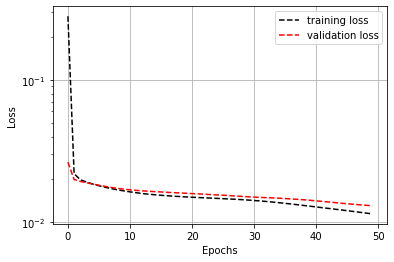

In [50]:
plt.semilogy(trn.history['loss'], 'k--', label='training loss')
plt.semilogy(trn.history['val_loss'], 'r--', label='validation loss')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [61]:
p = ae_model.predict(training_patterns[111:112]).reshape(60,NT)

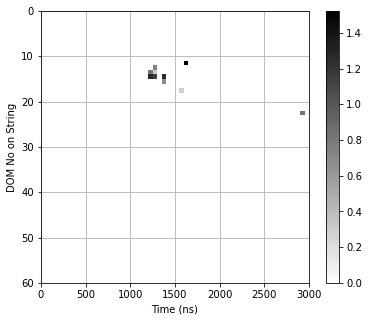

In [62]:
fig = plt.figure(figsize=(6, 5))
plt.imshow(training_patterns[111,:,:,0], cmap='binary', extent=(0, NT*50, 60, 0), aspect='auto')
plt.grid()
plt.xlabel('Time (ns)')
plt.ylabel('DOM No on String')
plt.colorbar()

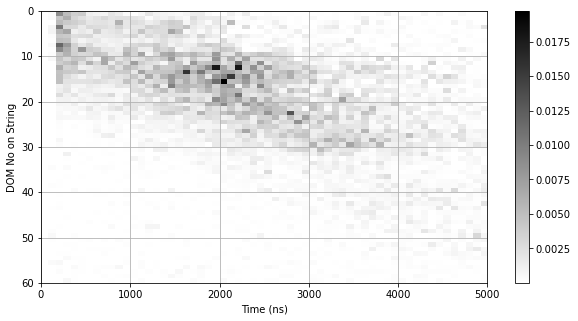

In [63]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(p, cmap='binary', extent=(0, 5000, 60, 0), aspect='auto')
plt.grid()
plt.xlabel('Time (ns)')
plt.ylabel('DOM No on String')
plt.colorbar()